Imported Biopython libraries and extracted the protein structure data from the 6VXX dataset (SarS-Cov2 proteins)

In [2]:
from Bio.PDB import PDBList, PDBParser, MMCIFParser

pdbl = PDBList()
pdbl.retrieve_pdb_file("6VXX")
parser = MMCIFParser()
file_path = "./vx/6vxx.cif"
structure = parser.get_structure("protein", file_path)

Structure exists: 'c:\Users\evanc\Documents\Data_Science_Programs\Protein_Analysis\vx\6vxx.cif' 


c:\Users\evanc\anaconda3\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 23232.
  warnings.warn(
c:\Users\evanc\anaconda3\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 23386.
  warnings.warn(
c:\Users\evanc\anaconda3\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 23540.
  warnings.warn(


Extracted atom displacements of each protein structure, converting them into a NumPy array for the SVM model. Each horizontal, vertical, and perpendicular displacement is formatted into individual vectors representing each molecule of protein structure.

71082
X: Horizontal Displacement of Molecules
Y: Vertical Displacement of Molecules
Z: Depth of Molecules along Perpendicular Direction


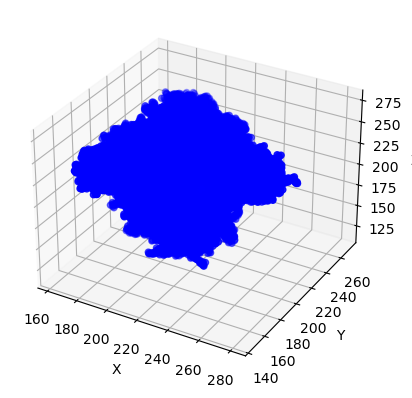

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

atoms = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                atoms.append(atom.get_coord())
atoms = np.array(atoms)
print(atoms.size)

plot = plt.figure()
ax = plot.add_subplot(111, projection='3d')
ax.scatter(atoms[:,0], atoms[:,1],atoms[:,2], c='b', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

print("X: Horizontal Displacement of Molecules")
print("Y: Vertical Displacement of Molecules")
print("Z: Depth of Molecules along Perpendicular Direction")

plt.show()

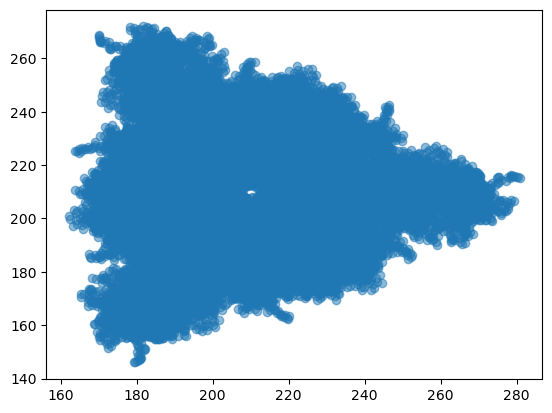

In [4]:
plt.scatter(atoms[:,0], atoms[:,1], alpha=0.5)

Extracting other features or annotations from the 6VXX dataset. Conducting feature engineering in order to filter features that provide high correlation with the molecular displacement vectors.

In [3]:
from sklearn.preprocessing import LabelEncoder

residueNames = []
heteroatoms = []
b_factors = []

for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                residueNames.append(residue.resname)
                heteroatoms.append(atom.element)
                b_factors.append(atom.bfactor)

b_factors = np.array(b_factors).reshape(-1,1)

le = LabelEncoder()
le.fit(heteroatoms)
heteroatoms = le.transform(heteroatoms)

X = np.hstack((atoms, b_factors))
y = heteroatoms

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SVC()

pipeline = Pipeline([
    ('Standard Scaler', scaler),
    ("svc", model)
])

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__degree': [3, 5, 7],
    'svc__gamma': ['scale', 'auto']
}

In [15]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, y_train)

In [ ]:
best_model = grid_search.best_estimator_
test = best_model.predict(X_test)
accuracy = accuracy_score(y_test, test)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.652
